## HLLEMNC
This is essentially a HLL solver with anti-diffusive terms which reduce contact wave dissipation.

Slight discrepancy in the results with flattener=1.  
Test 2 only works with flattener=0.

Most likely the eigenvalues or vectors have a bug.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,types,typeof
from numba.experimental import jitclass
import pandas as pd
style_file = '/home/monal/setup/mpl_plotting/thesis.mplstyle'
plt.style.use(style_file)

array = np.ndarray
real    = np.float64
integer = np.int64

In [2]:
@njit
def fill_ghost_cell(ng: integer, Q: array, bc_type: str) -> array:
  Q_border = np.zeros((Q.shape[0]+2*ng, Q.shape[1]), dtype=real)
  Q_border[ng:-ng,:] = Q
  if bc_type == "FOExtrap":
    Q_border[:ng,:] = Q[0,:]
    Q_border[-ng:,:] = Q[-1,:]
  elif bc_type == "periodic":
    Q_border[:ng,:] = Q[-ng:,:]
    Q_border[-ng:,:] = Q[:ng,:]
  elif bc_type == "reflect":
    Q_border[:ng,:] = Q[ng:-1:,:]
    Q_border[-ng:,:] = Q[-ng:-1:,:]
  else:
    raise NotImplementedError
  return Q_border

# @njit
# def minmod(a:real, b:real) -> real:
#   return real(0.5)*(np.sign(a)+ np.sign(b))*np.min(np.array([np.abs(a), np.abs(b)]))

@njit
def minmod(dQir: real, dQil: real) -> real:
  if dQir * dQil > real(0):  # Same sign
      dQi = np.min(np.array([np.abs(dQir), np.abs(dQil)])) * np.sign(dQir)
  else:  # Different sign or zero
      dQi = real(0.0)
  return dQi

spec = [('gam1', types.float64),('gam2', types.float64),('pi1', types.float64),('pi2', types.float64),('nlin', types.int64)]
@jitclass(spec)
class closures:
  def __init__(self, gam1, gam2, pi1, pi2):
    self.gam1 = gam1
    self.gam2 = gam2
    self.pi1  = pi1
    self.pi2  = pi2
    self.nlin = 5
    
  

In [3]:
@njit
def rhs(Q: real, dx: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> real:
  #  +  |   +   |  +
  #   i-1/2   i+1/2
  # i-1     i    i-1    
  #  ^-|^+
  
  # Fill ghost cells
  nx   = Q.shape[0]
  nxlo = ng
  nxup = ng + nx
  nfaces = nx+1
  nvar = Q.shape[1]
  Qn = fill_ghost_cell(ng, Q, bc_type)
  Vn = fill_ghost_cell(ng, Q, bc_type)
   # 0 1 2  nx+1 nx+2 nx+3
  # |+|+|....|+|+|

  # cons2prims
  for i in np.arange(nxlo-ng,nxup+ng,1):
    Vn[i,:] = Q2V(Qn[i,:],cls)
    
  # Compute slopes
  dQnmm = np.empty_like(Qn) # first index is -1th cell and last index is (nx+1)th cell 
  dVnmm = np.empty_like(Qn) # first index is -1th cell and last index is (nx+1)th cell 
  for i in np.arange(nxlo-1,nxup+1,1):
    for n in range(nvar):
      dQnmm[i,n] = minmod(Qn[i+1,n] - Qn[i,n], Qn[i,n] - Qn[i-1,n])#  Qn minmod
      dVnmm[i,n] = minmod(Vn[i+1,n] - Vn[i,n], Vn[i,n] - Vn[i-1,n])#  Qn minmod
 
  # Compute cell boundary values  
  Qnp   = np.empty_like(Qn)
  Qnm   = np.empty_like(Qn)
  for i in np.arange(nxlo-1,nxup+1,1):
    # for i-1/2 
    Qnm[i + 1,:] = Vn[i    ,:] + real(0.5)*dVnmm[i    ,:] # (QL,i+1/2) 
    Qnp[i    ,:] = Vn[i    ,:] - real(0.5)*dVnmm[i    ,:] # (QR,i-1/2) 
    
    # Qnm[i + 1,:] = Qn[i    ,:] + real(0.5)*dQnmm[i    ,:] # (QL,i+1/2) 
    # Qnp[i    ,:] = Qn[i    ,:] - real(0.5)*dQnmm[i    ,:] # (QR,i-1/2) 
 
  # prims2cons
  for i in np.arange(nxlo-1,nxup+1,1):
    Qnm[i+1,:] = V2Q(Qnm[i+1,:],cls)
    Qnp[i,:]   = V2Q(Qnp[i,:],cls)
    
  # Compute riemann problem for each face
  Dm   = np.empty_like(Qn)
  Dp   = np.empty_like(Qn)
  Fm   = np.empty_like(Qn)
  Fp   = np.empty_like(Qn)
  
  for i in np.arange(nxlo,nxup+1,1):
    Dm[i,:],Dp[i,:] = hllemnc(Qnm[i,:],Qnp[i,:], cls, i-ng)
    Fm[i,:] = Fi(Qnm[i,:],cls) #
    Fp[i,:] = Fi(Qnp[i,:],cls) #
    # if (i==200+ng):
    #   print('i=',i,'QL=',Qnm[i,:])
    #   print('i=',i,'QR=',Qnp[i,:])
    #   print('i=',i,'Vn=',Vn[i,:])
    #   raise UserWarning('here')
 
  
  # print(Dm.shape,Dp.shape)
  # Assemble RHS
  rhs  = np.empty_like(Q)
  for i in np.arange(nxlo,nxup,1):
    #   i        i+1/2     i-1/2
    # print(Dp)
    rhs[i-ng,:] = -(Dm[i+1,:] + Dp[i,:] + Fm[i+1,:]  - Fp[i,:]+ Bi(Qn[i,:],cls)@dQnmm[i,:])/dx
  
    # if (i==200+ng):
    #   print('i=',i,'rhs=',rhs[i-ng,:])
    #   print('i=',i,'Dm=',Dm[i+1,:])
    #   print('i=',i,'Dp=',Dp[i,:])
    #   print('i=',i,'Fm=',Fm[i+1,:])
    #   print('i=',i,'Fp=',Fp[i,:])
    #   raise UserWarning('Exit Early')
    
  
  # print('B.dQdx',Bi(Qn[200,:])@dQnmm[200,:]/dx)

  return rhs

@njit
def rk3(Q: array, dx: real, dt: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> array:
  # SSP-RK3
  Q1 = Q + dt * (rhs(Q, dx, ng, cls, bc_type))
  Q2 = real(0.75) * Q + real(0.25) * (Q1 + dt * (rhs(Q1, dx, ng, cls, bc_type)))
  return (Q + real(2.)*(Q2 + dt * (rhs(Q2, dx, ng, cls, bc_type)))) / 3

@njit
def euler(Q: array, dx: real, dt: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> array:
  return Q + dt * (rhs(Q, dx, ng, cls, bc_type))

In [4]:
@njit
def hllemnc(QL: array, QR: array, cls: closures, ii:int ) -> (array,array) :
  tol = real(1e-12)
  MaxIter = 25
  flattener = np.real(1.0)
  nvar = QL.shape[0]
  
  # print('HLLEMNC------------')
  # print('QL:',QL)
  # print('QR:',QR)
  # QM = np.zeros_like(QL)
  # LM = np.zeros_like(QL)
  # LL = np.zeros_like(QL)
  # LR = np.zeros_like(QL)
  # fL = np.zeros_like(QL)
  # fR = np.zeros_like(QL)
  
  # Compute eigenvals and fluxes for L and R
  QM = real(0.5)*(QL+QR) # Compute the intermediate state \bar{Q}
  LM = lambdas(QM, cls) # Compute the eigenvalues in QM
  LL = lambdas(QL, cls) # Compute the eigenvalues in QL
  LR = lambdas(QR, cls) # Compute the eigenvalues in QR
  sL = np.min(np.array([real(0.0), np.min(LM), np.min(LL)])) # Compute the left signal speed sL
  sR = np.max(np.array([real(0.0), np.max(LM), np.max(LR)])) # Compute the right signal speed sR
  # print(np.max(LL),np.max(LM),np.max(LR), sR)
  fL = Fi(QL, cls)
  fR = Fi(QR, cls)
  
  
#   print('fL:',fL)
#   print('fR:',fR)

#   print('sL:',sL)
#   print('sR:',sR)
  
  # BRoe1   = np.zeros((nvar,nvar),dtype=real)
  # BRoe2   = np.zeros((nvar,nvar),dtype=real)
  # PathInt = np.zeros(nvar,dtype=real)
  # temp = np.zeros((nvar,nvar))
  BRoe1 = RoeMatrix(QL,QR,cls) # Compute the Roe matrix (exactly or numerically)
  PathInt = BRoe1@(QR-QL) + fR - fL # Compute the path integral from QL to QR
  # if (ii==200):
  #   print('QR-QL',QR-QL)
  #   print('BRoe1',BRoe1)
  #   print('FR-FL',fR-fL)
  #   print('QR-QL',(QR-QL))
  #   print('PathInt start',PathInt)
  #   raise UserWarning("stopping HLLEMNC")
  
  QHLL = ( QR*sR - QL*sL - PathInt ) / (sR-sL) # Compute the initial guess for Q∗
  # if (ii==200):
  #   print('QHLL start',QHLL)
    # print('QR-QL',QR-QL)
  #   print('QL',QL)
  #   print('Fl',fL)
  #   print('FR',fL)
  #   print('sR sL',sR,sL)
    # print('PathInt start',PathInt)
  #   raise UserWarning("stopping HLLEMNC")

  # Simple Picard-type iteration to compute the HLL state Q∗
  for iHLL in range(MaxIter):

    QOld = QHLL # Save the old HLL state
    BRoe1 = RoeMatrix(QL,QHLL,cls) # Compute the Roe matrix between QL and Q∗
    BRoe2 = RoeMatrix(QHLL,QR,cls) # Compute the Roe matrix between Q∗ and QR
    PathInt = BRoe1@(QHLL-QL) + BRoe2@(QR-QHLL) + fR - fL
    QHLL = ( QR*sR - QL*sL - PathInt ) / (sR-sL) # Update the HLL state according to (16)
    res = np.sum(np.abs(QOld[:]-QHLL[:]))
    # if (ii==200):
    #   print('iHLL=',iHLL)
    #   print('PathInt',PathInt)
    #   print('QHLL',QHLL)
    #   print('error_vec',np.abs(QOld[:]-QHLL[:]))
    #   print('res',res)
    if(res < tol):
      break # Exit the loop if a tolerance has been reached
  if(res > tol):
    print('Q* and Path Integral not converged  ','iHLL=',iHLL, "  res=",res)
  # if (ii==200):
  #   print('PathInt end',PathInt)
  #   print('QHLL end',QHLL)
  #   raise UserWarning("stopping HLLEMNC")


  # Compute the lineraly degenerate fields (Modification to traditional HLLE)
  Id = np.identity(cls.nlin,dtype=real) # Define the identity matrix I
#   Delta = np.zeros((cls.nlin,cls.nlin),dtype=real)
#   Lap = np.zeros((cls.nlin,cls.nlin),dtype=real)
#   Lam = np.zeros((cls.nlin,cls.nlin),dtype=real)
#   Lambda = np.zeros((cls.nlin,cls.nlin),dtype=real)
#   RS = np.zeros((nvar,cls.nlin),dtype=real)
#   LS = np.zeros((cls.nlin,nvar),dtype=real)
#   AD = np.zeros(nvar,dtype=real)
  
#   temp1 = np.zeros((cls.nlin,nvar),dtype=real)
  
  Lambda,RS,LS = intermediate_linear_fields(QM, cls) # Compute Lambda∗, R∗ and L∗
  Lap = real(0.5)*( Lambda + np.abs(Lambda) ) # Compute Lambda+
  Lam = real(0.5)*( Lambda - np.abs(Lambda) ) # Compute Lambda- 
  Delta = Id - Lam/(sL-real(1e-14)) - Lap/(sR+real(1e-14)) # Compute δ∗
  # Compute the HLL flux and the final HLLEM flux
  flux = (sR*fL - sL*fR)/(sR-sL) + (sL*sR/(sR-sL))*(QR-QL) # HLL flux
  # Compute the anti-diffusive term of the HLLEM RS
  temp1 = LS@(QR-QL)
  temp2 = Delta@temp1
  AD = (sR*sL/(sR-sL))*(RS@temp2)
  
  # if (ii==200):
  #   print('AD',AD)
    # raise UserWarning("stopping HLLEMNC")

  # if (sum(PathInt)>1e-1):
    # print('Path Integral:',PathInt)
  # Compute the HLL fluctuations and the final HLLEM fluctuations
  Dm = -sL/(sR-sL)*PathInt + (sL*sR/(sR-sL))*(QR-QL) # Left-moving HLL fluctuation
  Dp = +sR/(sR-sL)*PathInt - (sL*sR/(sR-sL))*(QR-QL) # Right-moving HLL fluctuation
  
  # if (ii==200):
  #   print('Dp HLL conservative',-(sL*sR/(sR-sL))*(QR-QL))
  #   print('Dp HLL non-conserv ',sL/(sR-sL)*PathInt)
  #   print('Dp/dx',Dp/0.0025)
  #   raise UserWarning("stopping HLLEMNC")
    # print('sR sL',sR,sL)
    
  # print('Dm,Dp without HLL flux!')
  Dm = Dm - flattener*AD # Left-moving HLLEM fluctuation
  Dp = Dp + flattener*AD # Right-moving HLLEM fluctuation

  # if (ii==200):
  #   print('Dm',Dm)
  #   print('Dp',Dp)

    
  # print('---------')
  return Dm, Dp

@njit
def RoeMatrix(Qa:array,Qb:array,cls:closures) -> array:
  nGP = 3 # number of Gauss–Legendre points
  nvar = Qa.shape[0]
  # Definition of the Gauss–Legendre quadrature rule using 3 quadrature points
  sGP = np.array([ real(0.5)-np.sqrt(15.)/10., real(0.5), real(0.5)+np.sqrt(15.)/10.],dtype=real)
  wGP = np.array([ real(5.)/18., real(8.)/18., real(5.)/18. ],dtype=real)
  BRoe = np.zeros((nvar,nvar),dtype=real) # Initialize Roe matrix with zero
  
  for i in range(nGP):
    Q = Qa + sGP[i]*(Qb-Qa) # Straight-line segment path
    BRoe = BRoe + wGP[i]*Bi(Q,cls) # Compute the path integral using numerical quadrature
    # print('------')
    # print('Q',Q)
    # print('B',Bi(Q,cls))
    # print('Brhoe',BRoe)
  return BRoe

## Test case 2: Baer-Nunziato

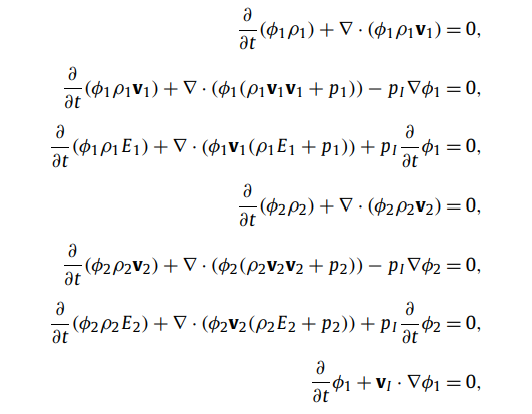

In [5]:
# Q = [φ1ρ1, φ1ρ1u1 ,φ1ρ1v1, φ1ρ1 E1, φ2ρ2, φ2ρ2u2 ,φ2ρ2v2, φ2ρ2 E2, φ1]
# V = [ρ1, u1, v1, p1, ρ2, u2, v2, p2, φ1]
#      V0 , V1, V2, V3
# 1 is solid and 2 is gas
# phi_small = 1e-8
@njit
def dQdV(Vi: array, cls:closures) -> array :
    # Extract state variables from Vi
    rho1 = Vi[0]
    u1 = Vi[1]
    v1 = Vi[2]
    p1 = Vi[3]

    rho2 = Vi[4]
    u2 = Vi[5]
    v2 = Vi[6]
    p2 = Vi[7]

    phi1 = Vi[8]
    phi2 = 1.0 - phi1  # Ensure phi2 is computed correctly

    ek1 = 0.5*(u1**2 + v1**2)  # Kinetic energy of phase 1
    ek2 = 0.5*(u2**2 + v2**2)  # Kinetic energy of phase 2

    # Initialize the Jacobian matrix (9x9) with zeros
    jac = np.zeros((9, 9), dtype=real)

    # Assign values element-wise

    # First row
    jac[0, 0] = phi1
    jac[0, 8] = rho1

    # Second row
    jac[1, 0] = phi1 * u1
    jac[1, 1] = phi1 * rho1
    jac[1, 8] = rho1 * u1

    # Third row
    jac[2, 0] = phi1 * v1
    jac[2, 2] = phi1 * rho1
    jac[2, 8] = rho1 * v1

    # Fourth row (Energy equation for phase 1)
    jac[3, 0] = phi1 * ek1
    jac[3, 1] = phi1 * rho1 * u1
    jac[3, 2] = phi1 * rho1 * v1
    jac[3, 3] = phi1 / (cls.gam1 - 1)
    jac[3, 8] = (p1 + cls.gam1 * cls.pi1) / (cls.gam1 - 1) + rho1 * ek1

    # Fifth row
    jac[4, 4] = phi2
    jac[4, 8] = -rho2

    # Sixth row
    jac[5, 3] = phi2 * u2
    jac[5, 5] = phi2 * rho2
    jac[5, 8] =-rho2 * u2

    # Seventh row
    jac[6, 4] = phi2 * v2
    jac[6, 6] = phi2 * rho2
    jac[6, 8] =-rho2 * v2

    # Eighth row (Energy equation for phase 2)
    jac[7, 4] = phi2 * ek2
    jac[7, 5] = phi2 * rho2 * u2
    jac[7, 6] = phi2 * rho2 * v2
    jac[7, 7] = phi2 / (cls.gam2 - 1)
    jac[7, 8] = -(p2 + cls.gam2 * cls.pi2) / (cls.gam2 - 1) - rho2 * ek2

    # Ninth row (Closure equation)
    jac[8, 8] = 1.0

    return jac

@njit
def Bi(Qi: array, cls:closures) -> array:
  Vi = Q2V(Qi,cls)
  rho1= Vi[0]
  u1  = Vi[1]
  v1  = Vi[2]
  p1  = Vi[3]
  
  rho2= Vi[4]
  u2  = Vi[5]
  v2  = Vi[6]
  p2  = Vi[7]
  
  uI = u1
  pI = p2
  
  nvar = Qi.shape[0]
  Bi = np.zeros((nvar,nvar),dtype=real)
  Bi[1,8] = -pI
  Bi[3,8] = -pI*uI
  
  Bi[5,8] = pI
  Bi[7,8] = pI*uI
  
  Bi[8,8] = uI
  
  return Bi

@njit
def Fi(Qi: array,cls:closures) -> array:
  Vi = Q2V(Qi, cls)
  rho1= Vi[0]
  u1  = Vi[1]
  v1  = Vi[2]
  p1  = Vi[3]

  rho2= Vi[4]
  u2  = Vi[5]
  v2  = Vi[6]
  p2  = Vi[7]
  phi1= Vi[8]
  phi2= real(1.0) - phi1 
  
  ek1 = real(0.5)*(u1*u1 + v1*v1) 
  ek2 = real(0.5)*(u2*u2 + v2*v2)

  rho1_E1 = (p1+cls.gam1*cls.pi1)/(cls.gam1-1) + rho1*ek1
  rho2_E2 = (p2+cls.gam2*cls.pi2)/(cls.gam2-1) + rho2*ek2
  
  Fi = np.array([phi1*rho1*u1,
                 phi1*(rho1*u1*u1 + p1),
                 rho1*u1*v1,
                 phi1*u1*(rho1_E1 + p1),
                 phi2*rho2*u2,
                 phi2*(rho2*u2*u2 + p2),
                 rho2*u2*v2,
                 phi2*u2*(rho2_E2 + p2),
                 0
                ],dtype=real)
  return Fi

@njit
def Q2V(Qi: array, cls:closures) -> array: 
  Vi = np.zeros_like(Qi,dtype=real)

  phi1 = Qi[8]
  phi2 = real(1.0) - phi1
  rho1 = Qi[0]/phi1
  rho2 = Qi[4]/phi2

  u1 = Qi[1]/Qi[0]
  v1 = Qi[2]/Qi[0]
  
  u2 = Qi[5]/Qi[4]
  v2 = Qi[6]/Qi[4]
  
  E1 = Qi[3]/phi1
  E2 = Qi[7]/phi2
  p1 = (cls.gam1 - real(1.0))*(E1 - real(0.5)*rho1*(u1*u1 + v1*v1)) - cls.gam1*cls.pi1
  p2 = (cls.gam2 - real(1.0))*(E2 - real(0.5)*rho2*(u2*u2 + v2*v2)) - cls.gam2*cls.pi2

  Vi[0] = rho1 # density of solid phase
  Vi[1] = u1   # x velocity of solid phase
  Vi[2] = v1   # y velocity of solid phase 
  Vi[3] = p1   # pressure of solid phase
  
  Vi[4] = rho2 # density of gas phase
  Vi[5] = u2   # x velocity of gas phase
  Vi[6] = v2   # y velocity of gas phase 
  Vi[7] = p2   # pressure of gas phase
  Vi[8] = phi1 # volume fraction of solid phase

  return Vi

@njit
def V2Q(Vi: array, cls:closures) -> array: 
  Qi = np.zeros_like(Vi,dtype=real)
  rho1 = Vi[0]  # density of solid phase
  u1   = Vi[1]  # x velocity of solid phase
  v1   = Vi[2]  # y velocity of solid phase
  p1   = Vi[3]  # pressure of solid phase

  rho2 = Vi[4]  # density of gas phase
  u2   = Vi[5]  # x velocity of gas phase
  v2   = Vi[6]  # y velocity of gas phase
  p2   = Vi[7]  # pressure of gas phase
  phi1 = Vi[8]  # volume fraction of solid phase
  phi2 = real(1.0) - phi1
  
  Qi[0] = phi1*rho1
  Qi[1] = Qi[0]*u1
  Qi[2] = Qi[0]*v1
  Qi[3] = phi1*((p1 + cls.gam1*cls.pi1)/(cls.gam1-real(1.))  + rho1*real(0.5)*(u1*u1 + v1*v1))
  Qi[4] = phi2*rho2
  Qi[5] = Qi[4]*u2
  Qi[6] = Qi[4]*v2
  Qi[7] = phi2*((p2 + cls.gam2*cls.pi2)/(cls.gam2-real(1.))  + rho2*real(0.5)*(u2*u2 + v2*v2))
  Qi[8] = phi1

  return Qi

@njit
def lambdas(Qi:array, cls:closures) -> array:
  Vi = Q2V(Qi,cls)
  rho1= Vi[0]
  u1  = Vi[1]
  v1  = Vi[2]
  p1  = Vi[3]
  rho2= Vi[4]
  u2  = Vi[5]
  v2  = Vi[6]
  p2  = Vi[7]
  
  c1= np.sqrt(cls.gam1*(p1+cls.pi1)/rho1)
  c2= np.sqrt(cls.gam2*(p2+cls.pi2)/rho2)

  return np.array([u1, u1+c1, u1-c1, u1, u2+c2, u2-c2, u2, u2, u1],dtype=real)

@njit
def intermediate_linear_fields(Qi:array, cls:closures) -> (array,array,array):
  nvar = Qi.shape[0]
  Lam  = np.zeros((cls.nlin,cls.nlin),dtype=real)
  R = np.zeros((nvar,cls.nlin),dtype=real)
  L = np.zeros((cls.nlin,nvar),dtype=real)

  Vi = Q2V(Qi,cls)
  rho1 = Vi[0]  # density of solid phase
  u1   = Vi[1]  # x velocity of solid phase
  v1   = Vi[2]  # y velocity of solid phase
  p1   = Vi[3]  # pressure of solid phase

  rho2 = Vi[4]  # density of gas phase
  u2   = Vi[5]  # x velocity of gas phase
  v2   = Vi[6]  # y velocity of gas phase
  p2   = Vi[7]  # pressure of gas phase
  phi1 = Vi[8]  # volume fraction of solid phase
  phi2 = real(1.0) - phi1
  
  c1= np.sqrt(cls.gam1*(p1+cls.pi1)/rho1)
  c2= np.sqrt(cls.gam2*(p2+cls.pi2)/rho2)
  
  Lam[:,:] = real(0.0)
  Lam[0,0] = u1
  Lam[1,1] = u1
  Lam[2,2] = u1
  Lam[3,3] = u2
  Lam[4,4] = u2
  
  # Right matrix eigenvectors
  R[:,:]= real(0.0)
  R[0,1]= real(1.)
  
  R[2,0]= real(1.)
  
  R[3,2]= phi2*(p2-p1)*((u1-u2)**2-c2*c2)/(phi1*rho2)
  
  R[4,2]= (u1-u2)**2 
  R[4,4]= real(1.)
  
  R[5,2] =c2*c2*(u1-u2)/rho2 
  
  R[6,3] = real(1.)

  R[7,2] = c2*c2*(u1-u2)**2
  
  R[8,2] = phi2*((u1-u2)**2-c2*c2)/rho2

  jac = dQdV(Vi,cls)
  R[:,:] =  jac@R
  
  # Left matrix eigenvectors
  jac_inv  = np.linalg.inv(jac)
  L[:,:]= real(0.)
  L[0,2]= real(1.)
  
  L[1,0]= real(1.)
  L[1,3]=-real(1.)/(c1*c1)
  L[1,8]= (p2-p1)/(phi1*c1*c1)
  
  L[2,8]= rho2/(phi2*((u1-u2)**2-c2*c2))
  
  L[3,6]= real(1.)
  
  L[4,4]= real(1.)
  L[4,7]=-real(1.)/(c2*c2)
  L[:,:]=L@jac_inv
  
  return Lam,R,L

@njit
def riemann_ic(x: real, nvar: int, case: int, cls:closures) -> array:
    # Initialize an array of zeros with shape (len(x), nvar)
    Q = np.zeros((x.shape[0], nvar),dtype=real)

    # Define left and right states for the Riemann problem
    if (case==0):
      # RP0
      Vil = np.array([1.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 1.0, 0.4],dtype=real)
      Vir = np.array([2.0, 0.0, 0.0, 2.0, 1.5, 0.0, 0.0, 2.0, 0.8],dtype=real)
      xd = 0.0
    elif (case==1):
      ValueError("case",case,"does not exist")
      #RP1
      Vil = np.array([800.00, 0.0, 0.0, 500.0, 1.5, 0.0, 0.0, 2.0, 0.4],dtype=real)
      Vir = np.array([1000.0, 0.0, 0.0, 600.0, 1.0, 0.0, 0.0, 1.0, 0.3],dtype=real)
      xd = 0.0
    elif (case==2):
      ValueError("case",case,"does not exist")
      #RP2
      Vil = np.array([1.0, 0.9, 0.0, 2.5, 1.0, 0.0, 0.0, 1.0, 0.9],dtype=real)
      Vir = np.array([1.0, 0.0, 0.0, 1.0, 1.2, 1.0, 0.0, 2.0, 0.2],dtype=real)
      xd = 0.0
    else:
      ValueError("case",case,"does not exist")

    Qil = V2Q(Vil,cls)
    Qir = V2Q(Vir,cls)
    # Loop through each element in x
    for i, xi in enumerate(x):
        if xi < xd:
            Q[i, :] = Qil
        else:
            Q[i, :] = Qir
    return Q

In [6]:
# Test cons2prims, cons2prims and dQdv.
@njit
def test():
  pi1 = 0.0
  pi2 = 0.0
  gam1 = 1.4
  gam2 = 1.4
  constants = closures(gam1,gam2,pi1,pi2)
  Vtest = np.array([2.0, 0.0, 0.0, 2.0, 1.5, 0.0, 0.0, 2.0, 0.8],dtype=real)
  print('prim=',Vtest)
  print('cons=',V2Q(Vtest, constants))
  print('prim=',Q2V(V2Q(Vtest, constants), constants))
  
  Qtest = V2Q(Vtest,constants)
  jac1 = dQdV(Vtest,constants) 
  # jac2 = dVdQ(Qtest,constants) 

  inv = np.linalg.inv(jac1)
  # print('dQdV.dVdQ=',jac1@jac2)
  print('dQdV.inv=',jac1@inv)
  
test()

prim= [2.  0.  0.  2.  1.5 0.  0.  2.  0.8]
cons= [1.6 0.  0.  4.  0.3 0.  0.  1.  0.8]
prim= [2.  0.  0.  2.  1.5 0.  0.  2.  0.8]
dQdV.inv= [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


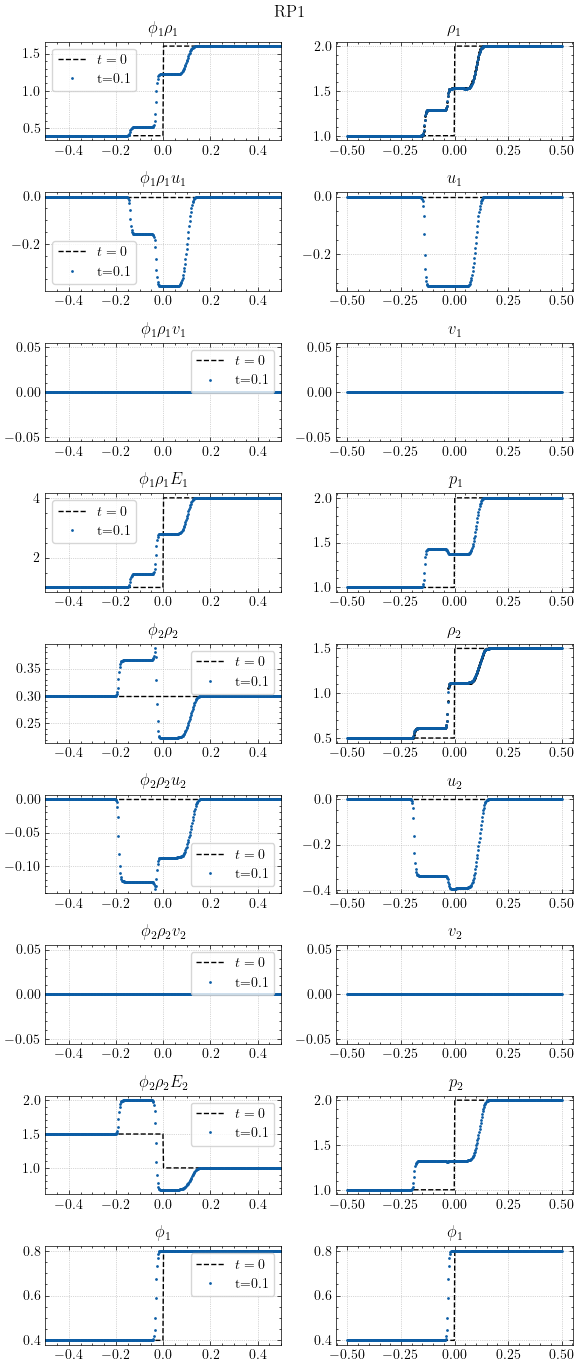

In [7]:
case = 0
nvar = 9
nlin  = 5 
ng = 2
nx = 400
lxs=real(-0.5)
lxe=real( 0.5)

# constant dt
if (case==0):
  t_end = real(0.1)
  dt = real(0.001)
  constants = closures(1.4,1.4,0,0)
elif (case==1):
  constants = closures(3.0,1.4,100.0,0)
  t_end = real(0.1)
  dt=real(0.0004)/2
elif (case==2):
  t_end = 0.1
  dt=real(0.0005)
  constants = closures(1.4,1.4,0,0)
else:
  ValueError('case does not exist')

dx = (lxe-lxs)/nx
x = np.linspace(lxs-dx/2, lxe+dx/2, nx, dtype=real)
Q = riemann_ic(x,nvar,case, constants)

fig, axes = plt.subplots(nvar,2)
fig.set_size_inches([6,14])
fig.suptitle('RP'+str(case+1))#, fontsize=16)
labels_cons = [r'$\phi_1 \rho_1$', r'$\phi_1 \rho_1 u_1$', r'$\phi_1 \rho_1 v_1$', r'$\phi_1 \rho_1 E_1$', 
          r'$\phi_2 \rho_2$', r'$\phi_2 \rho_2 u_2$', r'$\phi_2 \rho_2 v_2$', r'$\phi_2 \rho_2 E_2$',  '$\phi_1$']
labels_prims = [r'$\rho_1$', r'$u_1$', r'$v_1$', r'$p_1$', r'$\rho_2$', r'$u_2$', r'$v_2$', r'$p_2$', r'$\phi_1$']
# load ref data
ref = pd.read_csv('./Baer-Nunziato/1D/results/RP' + str(case+1) +'.csv')
rho1_ref = ref.iloc[:,1]
rho2_ref = ref.iloc[:,4]
x_ref = ref.iloc[:,0]
#plotref
axes[0,1].plot(x_ref,rho1_ref, label='ref', linestyle='', marker='o', markersize=1, color='black', markerfacecolor="None")
axes[4,1].plot(x_ref,rho2_ref, label='ref', linestyle='', marker='o', markersize=1, color='black', markerfacecolor="None") 

for i in range(nvar):
  # plot cons
  axes[i,0].set_title(labels_cons[i])
  axes[i,0].plot(x, Q[:,i], 'k--', label=rf"$t = 0$")
  
  #plot prims
  V = np.zeros_like(Q)
  for ii in range(nx):
    V[ii,:] = Q2V(Q[ii,:],constants)
  axes[i,1].set_title(labels_prims[i])
  axes[i,1].plot(x, V[:,i], 'k--', label=rf"$t = 0$")

nt_max = int(t_end/dt)
time = 0
for i in range(nt_max):
  lambda_max=-1e-10
  for ii in range(Q.shape[0]):
    L = np.abs(lambdas(Q[ii,:],constants))
    lambda_max = np.max([np.max(L),lambda_max])
  
  CFL = lambda_max * dt/dx
  if (CFL>1.0 or np.isnan(CFL) or CFL<0.0): 
    ValueError("CFL wrong")
  print("iter=",i+1, "/",nt_max,"  dt=",np.round(dt,4), "  dx=", np.round(dx,4),
        "  Lmax=", np.round(lambda_max,4), "  CFL=",np.round(CFL,4) , end='\r')
  Q = rk3(Q, dx, dt, ng, constants, bc_type="FOExtrap")
  time = dt+time
  # break
  # if (i==1): break

for i in range(nvar):
  #plot cons
  axes[i,0].plot(x, Q[:,i],linestyle='', label="t="+str(np.round(time,3)), marker='o', markersize=1,markerfacecolor="None")
  axes[i,0].legend()
  axes[i,0].set_xlim([-0.5,0.5])
  
  #plot prims
  V = np.zeros_like(Q)
  for ii in range(nx):
    V[ii,:] = Q2V(Q[ii,:],constants)
  axes[i,1].set_title(labels_prims[i])
  axes[i,1].plot(x, V[:,i],  linestyle='', label="t="+str(np.round(time,3)), marker='o', markersize=1,markerfacecolor="None")


plt.tight_layout()
# plt.savefig('./RP_AD'+str(case+1)+'.pdf',dpi=600,format="pdf", bbox_inches="tight")
# plt.savefig('./RP'+str(case+1)+'.png',dpi=600,format="png", bbox_inches="tight"